In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 라이브러리 import

In [15]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision

## Device 설정

In [9]:
# device 설정
# 만약 cuda 설정이 되어있지 않다면 cpu를 사용한다
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## 데이터 Load 및 Preprocessing

In [17]:
batch_size = 100

# 방대한 데이터 이미지를 한번에 변형 (데이터 전처리)
transform = transforms.Compose(
    [transforms.ToTensor(), # 이미지를 Pytorch tensors 타입으로 변형 / pixels 값들을 [0~255]에서 [0.0~1.0]으로 자동 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # 각 channel에 맞춰서 normalize 진행
)

cifar10_train = datasets.CIFAR10(root='/content/',train=True,transform=transform,target_transform=None,download=True)
cifar10_test = datasets.CIFAR10(root="/content/", train=False, transform=transform, target_transform=None, download=True)

# cifar10_train, cifar10_test 데이터를 미리 설정한 batch_size(100) 형태로 만들어 train_loader, test_loader 변수에 넣는다
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### 데이터 시각화

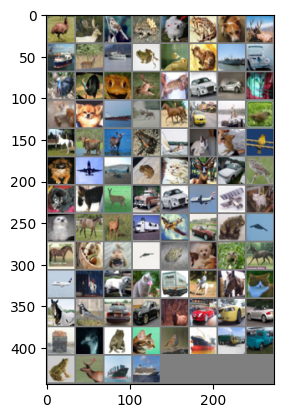

 bird  deer  bird  frog   dog  frog   dog  deer  ship  deer  ship  frog  bird   cat  ship  ship  bird  bird  frog  deer   cat   car   car   cat   cat   dog  ship  deer horse   car  ship  bird horse  deer  deer  frog  ship   cat   cat  bird   dog plane plane  frog   cat  deer   car  bird   dog   cat  deer   car   car plane plane   cat   dog horse  deer truck plane   car  frog plane horse   dog   dog plane  frog   dog  frog horse plane horse   dog   cat truck horse horse   cat horse  bird   car   car  deer   car   car   car truck  bird  frog   cat  bird  ship truck   car  frog  deer  ship  ship


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    # unnormalize (시각화를 위해서)
    img = img / 2 + 0.5 #0~1 사이 형태에서 벗어나게 하기 위함??

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #이미지 차원 조절
    plt.show()

# 학습용 이미지를 무작위로 가져오기
images, labels = next(iter(train_loader))

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

# VGG16 Architecture
![이미지](https://miro.medium.com/v2/resize:fit:857/1*AqqArOvacibWqeulyP_-8Q.png)

합성곱 연산 2번(채널 64) ->
합성곱 연산 2번(채널 128) ->
합성곱 연산 3번(채널 256) ->
합성곱 연산 3번(채널 512) ->
합성곱 연산 3번(채널 512) ->
FC Layer 3번

- FC Layer 목록
  - FC Layer 4096
  - FC Layer 4096
  - FC Layer 1000 (카테고리 개수)

## 두 번째 합성곱 블록

In [6]:
def conv_2_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

## 세 번째 합성곱 블록

In [7]:
def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

In [8]:
class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG16, self).__init__()

        # 합성곱 블록을 포함한 특성 추출
        self.feature = nn.Sequential(
            conv_2_block(3, base_dim), # 입력 채널 3개, 출력 채널 base_dim개인 conv_2_block
            conv_2_block(base_dim, 2 * base_dim), # 입력 채널 base_dim개, 출력 채널 2*base_dim개인 conv_2_block
            conv_3_block(2 * base_dim, 4 * base_dim),  # 입력 채널 2*base_dim개, 출력 채널 4*base_dim개인 conv_3_block
            conv_3_block(4 * base_dim, 8 * base_dim),  # 입력 채널 4*base_dim개, 출력 채널 8*base_dim개인 conv_3_block
            conv_3_block(8 * base_dim, 8 * base_dim),  # 입력 채널 8*base_dim개, 출력 채널 8*base_dim개인 conv_3_block
        )

        # 완전 연결 레이어 영역
        self.fc_layer = nn.Sequential(
            nn.Linear(8 * base_dim * 1 * 1, 4096),  # fully connected layer. 입력 노드 수 : 8*base_dim*1*1 / 출력 노드 수 : 4096
            nn.ReLU(True),
            nn.Dropout(), # Dropout : 과적합 방지를 위한 Layer. 학습 중에 무작위로 일부 뉴런을 비활성화한다
            nn.Linear(4096, 4096), # fully connected layer. 입력 노드 수는 4096, 출력 노드 수는 4096
            nn.ReLU(True), # True : inplaceReLU 활성화 / inplaceReLU : ReLU 활수화 함수를 적용할 때 입력 텐서를 직접 수정하는 방식
            nn.Dropout(), # Dropout : 과적합 방지를 위한 Layer. 학습 중에 무작위로 일부 뉴런을 비활성화한다
            nn.Linear(1000, num_classes), # 마지막 FC Layer. 입력 노드 수는 1000, 출력 노드 수는 분류하고자 하는 카테고리의 개수(num_classes)
        )


    def forward(self, x):
        x = self.feature(x) # 입력 이미지 -> 특성 추출
        x = x.view(x.size(0), -1) # feature map > 일렬로 펼쳐서 완전 연결 레이어에 입력할 수 있는 형태로 변환
        x = self.fc_layer(x) # 완전 연결 레이어에 넣어 수행시킴
        return x

## hyperparameter 설정 및 모델 선언

In [20]:
num_epoch = 100
learning_rate = 0.0002

model = VGG16(base_dim=64).to(device)

In [21]:
# 손실 함수(loss_function)을 분류 함수로 설정
loss_func = nn.CrossEntropyLoss()

# 최적화 알고리즘(optimizer)을 Adam으로 설정
# learning rate : 모델이 학습을 진행할 때 각각의 가중치(weight)를 얼마나 업데이트할지 결정하는 하이퍼파라미터
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [22]:
loss_arr = []

# num_epoch 만큼 학습 진행
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        # torch.no_grad() : 기울기(gradient)를 계산하지 않는다.
        optimizer.zero_grad() #optimizer의 gradient를 0으로 설정

        output = model.forward(x)  # forward() : 모델이 학습 데이터를 입력 받아서 forward 연산 수행

        # 손실 값(loss) 저장
        loss = loss_func(output,y_)

        # backward() : 스칼라 값에 대한 출력 텐서의 gradient를 전달 받고, 동일한 스칼라 값에 대한 입력 텐서의 변화도 계산
        loss.backward()

        # 역전파 단계에서 수집된 변화도( backward() )로 매개변수 조정
        optimizer.step()

    # 학습 횟수가 10의 배수가 될때마다 출력
    if i % 10 ==0:
        print(f'epcoh {i} loss : ',loss) # 손실 값 출력


        # GPU 메모리에 올려져 있는 tensor를 numpy로 변환
        # cpu().detach().numpy()보단 detach().cpu().numpy()를 주로 사용하는 것 같다.
        loss_arr.append(loss.cpu().detach().numpy())

epcoh 0 loss :  tensor(1.8325, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 10 loss :  tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 20 loss :  tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 30 loss :  tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 40 loss :  tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 50 loss :  tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 60 loss :  tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 70 loss :  tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 80 loss :  tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
epcoh 90 loss :  tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


## 모델 평가 시각화 및 정확도 출력

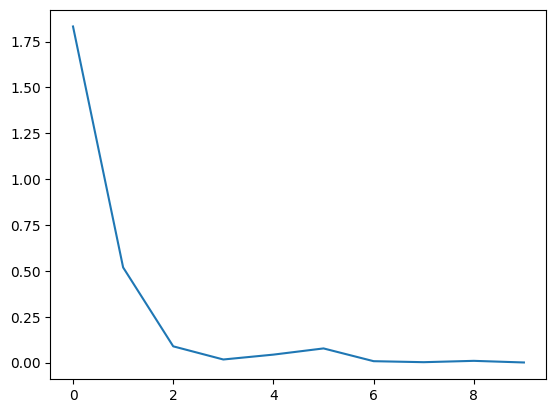

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [29]:
# 모델 평가에 사용될 변수 선언 및 모델 평가하기
correct = 0
total = 0
model.eval()

# torch.no_grad() : 기울기(gradient)를 계산하지 않는다.
with torch.no_grad():
    for i, [image, label] in enumerate(test_loader):
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x) # forward() : 모델이 학습 데이터를 입력 받아서 forward 연산 수행 / forward를 호출하여 입력 데이터를 모델에 전달
        _, output_index = torch.max(output, 1)  # 모델의 출력을 기반으로 예측 수행. torch.max 함수를 사용하여 출력 텐서 output에서 가장 큰 값의 인덱스를 찾는다.
                                                # torch.max(output, 1) : 각 행에서 (최대값, 해당 인덱스) 반환
        # 모델 평가에서 선언한 변수들의 값 계산
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 모델 정확도 출력
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 81.48999786376953%
